In [2]:
import os
import sys
import time
import copy
import tqdm
import glob
import numpy as np
import importlib
import segyio
from natsort import natsorted
from scipy import signal
import multiprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast

from IPython.display import clear_output

import utils.shared as sd
import utils.loaders as ld
import utils.vis as vis
import utils.backbone as backbone
from utils.torchsummary import summary

Fix random seeds to get some kind of reproducibility

In [3]:
torch.manual_seed(123)
np.random.seed(123)

Format plotting

In [2]:
import matplotlib as mpl
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
print(torch.__version__)
print(sys.version)
print(sys.prefix)

1.8.1+cu102
3.8.3 (default, Oct 11 2020, 17:10:44) 
[GCC 7.5.0]
/home/ovcharoo/work/env_torch


### Disable profiling etc for final training

In [4]:
torch.backends.cudnn.benchmark = True

# Uncomment below when you are sure the trainin is correst (it accelerates training)
torch.autograd.detect_anomaly = False
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile = False
torch.autograd.profiler.emit_nvtx = False
torch.autograd.gradcheck = False
torch.autograd.gradgradcheck = False

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

### Bandpass filters

{'high': {'flo': 4, 'btype': 'high', 'order': 8}, 'low': {'fhi': 5, 'btype': 'low', 'order': 8}, 'ulow': {'fhi': 2.5, 'btype': 'low', 'order': 8}}


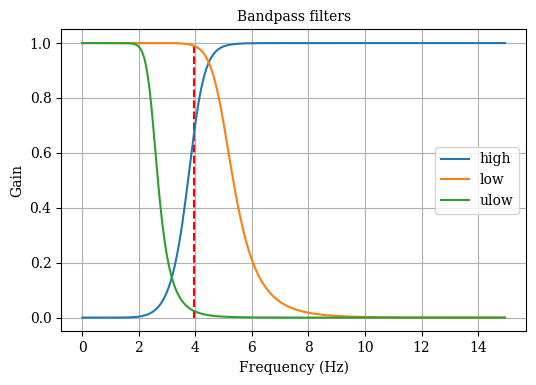

In [5]:
par = sd.par_default

# Sampling of input data to the network
dt = 0.016 # s
dx = 25.0 # m
par_shot = {'dt': dt, 'dx': dx}

# Shortcuts for spectra plotting
max_freq = 15; _max_freq = 4; _pclip=0.1; _colors = ['k--', 'b']; 
_rule_low={'fhi': 3, 'btype' : 'low'}; _keys_exclude = ['raw', 'mid']
vis.plot_filters(par['rules'], dt, max_freq, title='Bandpass filters', exclude=_keys_exclude, fedge=par['fedge'])
    
# vis.savefig('filters.png')

# Load data

In [6]:
# Routing to load the training data
root_data = './pretrained_files/data/'
    
path_syn = os.path.join(root_data, 'syn_1024_el/')
jloader_tr, jloader_te = sd.init_loaders(
                 root_src = path_syn,
                 root_dst = os.path.join(root_data, 'field_samples/'))

Load cubes from ./pretrained_files/data/syn_1024_el/...
(2765, 324, 376) (2765, 324, 376) (2765, 324, 376) (2765, 324, 376)
(154, 324, 376) (154, 324, 376) (154, 324, 376) (154, 324, 376)
(64, 324, 376) (64, 324, 376) (64, 324, 376) (64, 324, 376)
(64, 324, 376) (64, 324, 376) (64, 324, 376) (64, 324, 376)
Processed data loaders: 2765 154


### Add noise from field data to synthetic training data

In [7]:
# Load data with noise samples for particular frequency ranges
# High
root_noise = './pretrained_files/data/noise_donors/'
cube_hf = ld.make_noise_cube(os.path.join(root_noise, 'cube_dst_te_h.npy'))

# Add noise from field data to syntheitc data
jjloader_tr = ld.NoiseAdder(jloader_tr, cube_hf)
jjloader_te = ld.NoiseAdder(jloader_te, cube_hf)

# Data augmentation: flip along offset axis
jjloader_tr = ld.FlipLoader(jjloader_tr)
jjloader_te = ld.FlipLoader(jjloader_te)

Load ./pretrained_files/data/noise_donors/cube_dst_te_h.npy
(80, 324, 376)
(80, 324, 446)


## Explore the data
There are 10 outputs of the dataloader
```0 - syn input
1 - syn low
2 - syn ulow
3 - velocity model
4 - field input
5 - field low
6 - filed ulow
7 - velocity model (zeros)```

Plot all 10 in row

8


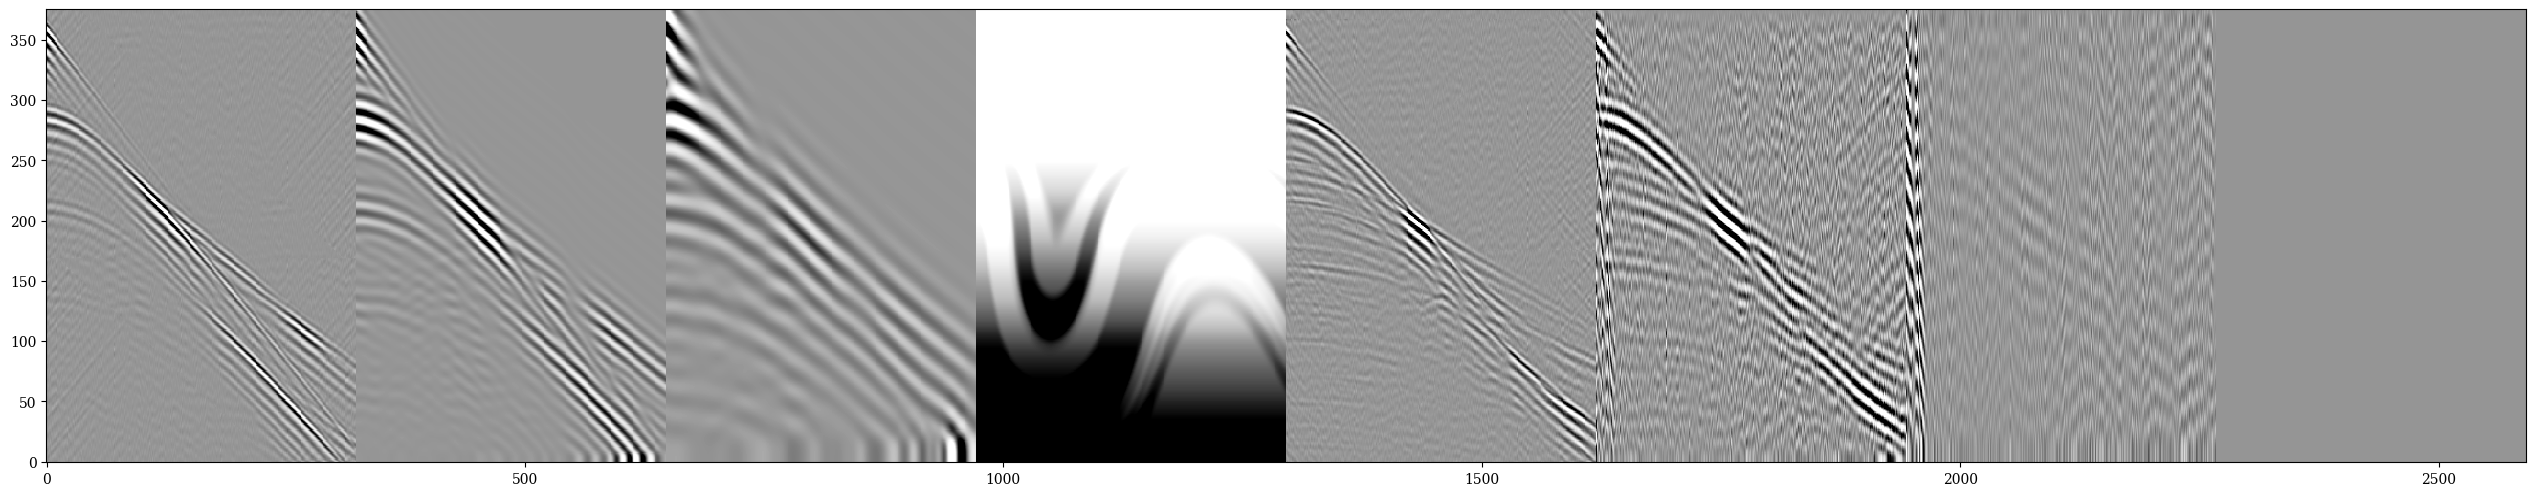

In [8]:
idx = 41
d = jjloader_tr.__getitem__(idx)
print(len(d))
no, nt = d[0].shape[-2:]
vis.plot_shot(np.concatenate([v[0, ...] for v in d[:10]]), pclip=0.25, figsize=(32,6), colorbar=False)
# vis.plot_shot(np.concatenate([v[0, ...] for v in d[9:]]), pclip=0.25, figsize=(32,6))
# NOTE: the real data subsurface is unknown, so there is always gonna be zero

High-frequency data vs subsurface model

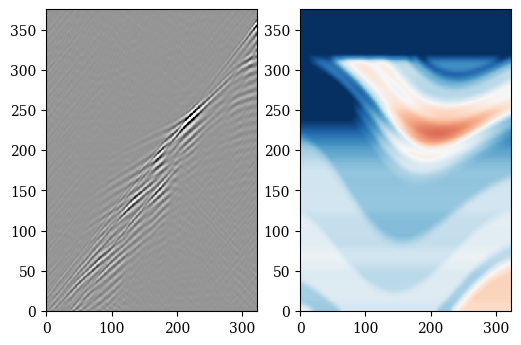

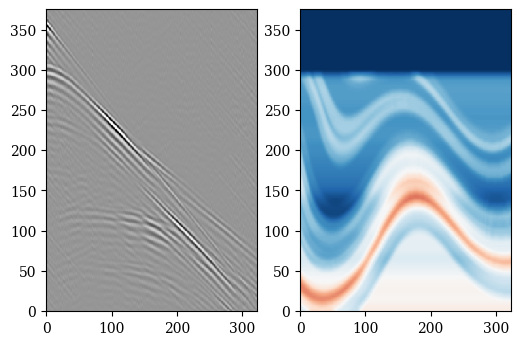

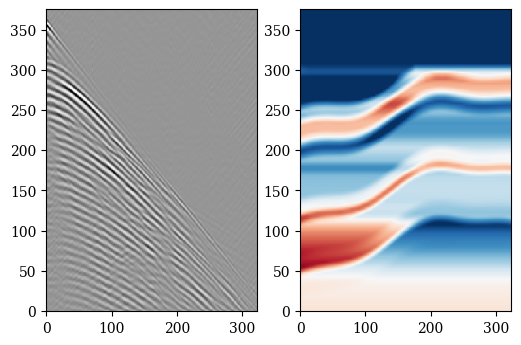

In [9]:
for i in np.random.randint(0, len(jjloader_te), 3):
    d = jjloader_te.__getitem__(i)
    no, nt = d[0].shape[-2:]
    fig, ax = plt.subplots(1,2)
    vis.plot_shot(d[0][0, ...], pclip=0.25, ax=ax[0], colorbar=False, vmin=-0.5, vmax=0.5)
    vis.plot_shot(d[3][0, ...], ax=ax[1], colorbar=False, cmap='RdBu_r', vmin=-1, vmax=1)

# Resize test
This is never used, but I was curious how much do we loose when resize - not much. Meaning that later the data might be reshaped into square to allow more general applications

In [10]:
# from skimage.transform import resize
# d = jjloader_te.__getitem__(0)

# data_init = d[2][0, ...]
# no, nt = data_init.shape[-2:]
# dim_square = 256

# data_init_i = resize(resize(data_init, (dim_square, dim_square)), (no, nt))
# vis.plot_shot(np.concatenate([data_init, data_init_i, data_init - data_init_i]), pclip=0.25, figsize=(32,6))